<a href="https://colab.research.google.com/github/viktory-41/rosnich_kompany_velikobrit/blob/main/ecommerce_ab_testing_2022_dataset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В рамках этого проекта вам предстоит разобраться в результатах A/B-тестирования, проведенного интернет-магазином. Компания разработала новую веб-страницу, чтобы попытаться увеличить количество пользователей, совершающих «конверсию», то есть количество пользователей, решивших оплатить продукт компании. Ваша задача — с помощью этого блокнота помочь компании понять, следует ли ей внедрить новую страницу, оставить старую или, возможно, продлить эксперимент, чтобы принять окончательное решение.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
df=pd.read_csv('/content/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0.0
1,804228,01:45.2,control,old_page,0.0
2,661590,55:06.2,treatment,new_page,0.0
3,853541,28:03.1,treatment,new_page,0.0
4,864975,52:26.2,control,old_page,1.0


In [5]:
df.shape

(174751, 5)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174751 entries, 0 to 174750
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       174751 non-null  int64  
 1   timestamp     174751 non-null  object 
 2   group         174750 non-null  object 
 3   landing_page  174750 non-null  object 
 4   converted     174750 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 6.7+ MB


In [22]:
df.isnull().sum()

,0
user_id,0
timestamp,0
group,1
landing_page,1
converted,1


Имеются пропуски в данных. Нужно убрать эти строки.

In [27]:
df=df.dropna()
df

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0.0
1,804228,01:45.2,control,old_page,0.0
2,661590,55:06.2,treatment,new_page,0.0
3,853541,28:03.1,treatment,new_page,0.0
4,864975,52:26.2,control,old_page,1.0
...,...,...,...,...,...
174745,742634,46:43.1,treatment,new_page,0.0
174746,792936,04:58.6,treatment,new_page,0.0
174747,823296,41:40.3,control,old_page,0.0
174748,781861,57:57.4,control,old_page,0.0


In [28]:
print(df.isnull().sum())

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


Теперь наш DataFrame во всех ячейках заполнен значениями. Всего строк: 174750

In [24]:
df_coun=pd.read_csv('/content/countries.csv')
df_coun.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [6]:
df_coun.shape

(290586, 2)

In [16]:
df_coun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290586 entries, 0 to 290585
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290586 non-null  int64 
 1   country  290586 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


Объединим наши два датафрейма в один, чтобы было удобнее искать информацию.

In [30]:
df_ob=df.merge(df_coun,how='left')
df_ob.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0.0,US
1,804228,01:45.2,control,old_page,0.0,US
2,661590,55:06.2,treatment,new_page,0.0,US
3,853541,28:03.1,treatment,new_page,0.0,US
4,864975,52:26.2,control,old_page,1.0,US


In [31]:
df_ob.nunique()

,0
user_id,173387
timestamp,35733
group,2
landing_page,2
converted,2
country,3


Заметим, что уникальных значений типа object всего 2 для признака group, landing_page, converted и 3 значения различных для country.

In [32]:
df_ob['converted'].mean()

np.float64(0.11998855507868383)

Общая конверсия по всем пользователям состовляет 12%.

In [33]:
df_ob['group'].value_counts()

,count
group,
treatment,87572
control,87178


In [34]:
df_ob['landing_page'].value_counts()

,count
landing_page,
new_page,87518
old_page,87232


group и landing_page пользователей распределены по классам сбалансировано.

In [36]:
df_ob.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0.0,US
1,804228,01:45.2,control,old_page,0.0,US
2,661590,55:06.2,treatment,new_page,0.0,US
3,853541,28:03.1,treatment,new_page,0.0,US
4,864975,52:26.2,control,old_page,1.0,US


# Проверим соответствие группы и страницы:
- В контрольной группе должна быть old_page
- В экспериментальной — new_page
- (если есть несоответствия — удалить)

In [38]:
df_ob.groupby(['group','landing_page'])['converted'].count()

group      landing_page
control    new_page         1163
           old_page        86015
treatment  new_page        86355
           old_page         1217
Name: converted, dtype: int64

Наблюдаем, что у нас есть строчки, где есть не соотвествие с условием, поэтому их удалим. Должно быть 86015+86355= 172370

In [66]:
df_clean=df_ob[((df_ob['group']=='control') & (df_ob['landing_page']=='old_page')) | (df_ob['group']=='treatment') & (df_ob['landing_page']=='new_page')]
df_clean.shape

(172370, 6)

# Проверим уникальность пользователей
Необходимо, чтобы каждый пользователь входил только в одну группу.

In [70]:
user_in_bouth=df_clean.groupby('user_id')['group'].count()
multi_group=user_in_bouth[user_in_bouth>1]
(multi_group)

,group
user_id,
773192,2


У нас нашелся один пользователь, который находится в двух группах, нужно его удалить.

In [69]:
df_final = df_clean[~df_clean['user_id'].isin(multi_group.index)].copy()
df_final.shape

(172368, 6)

# Рассчитаем конверсию по группам

In [73]:
conver_group=df_final.groupby('group')['converted'].agg(['mean','count','sum'])
conver_group.columns=['conversion_rate','users','conversions']
conver_group['conversion_rate']=conver_group['conversion_rate']*100
conver_group

,conversion_rate,users,conversions
group,,,
control,12.060687,86015,10374.0
treatment,11.932417,86353,10304.0


### Расчет lift (относительный прирост) составил:

In [75]:

control_conv = conver_group.loc['control', 'conversion_rate']
treatment_conv = conver_group.loc['treatment', 'conversion_rate']
lift = (treatment_conv - control_conv) / control_conv * 100
lift

np.float64(-1.0635393219242781)

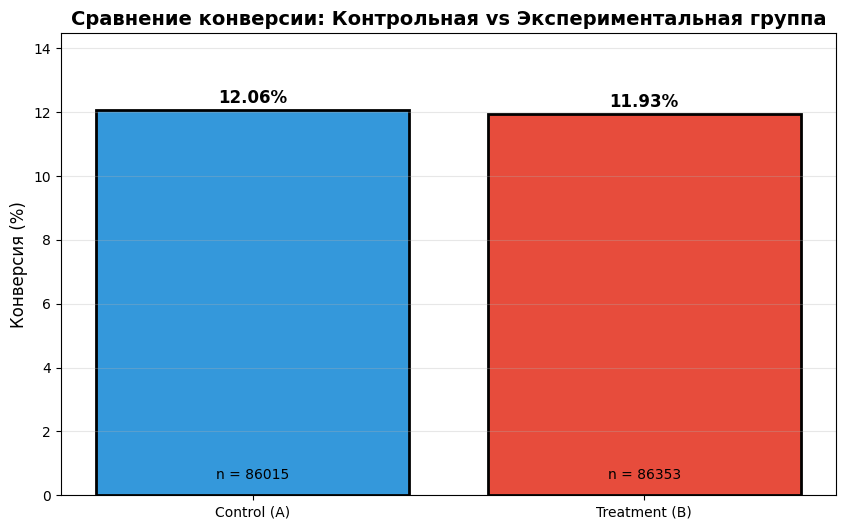

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Барплот с конверсией
bars = plt.bar(['Control (A)', 'Treatment (B)'],
               [control_conv, treatment_conv],
               color=['#3498db', '#e74c3c'],
               edgecolor='black',
               linewidth=2)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Конверсия (%)', fontsize=12)
plt.title('Сравнение конверсии: Контрольная vs Экспериментальная группа',
          fontsize=14, fontweight='bold')
plt.ylim(0, max(control_conv, treatment_conv) * 1.2)

# Добавляем информацию о размере выборки
plt.text(0, 0.5, f'n = {conver_group.loc["control", "users"]}',
         ha='center', fontsize=10)
plt.text(1, 0.5, f'n = {conver_group.loc["treatment", "users"]}',
         ha='center', fontsize=10)

plt.grid(True, alpha=0.3, axis='y')
plt.savefig('sravn_convers.png', dpi=300, bbox_inches='tight')
plt.show()

#Статистический тест

Будем проводить z-тест, alfa=0.05.

H0 гипотеза: статистической значимой разницы между группами нет.

H1 гипотеза: есть статистическая значимая разница между группами.

In [92]:
from scipy import stats
import statsmodels
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
contr_conv=df_final[df_final['group']=='control']['converted']
treatm_conv=df_final[df_final['group']=='treatment']['converted']

succes_conv=[sum(contr_conv), sum(treatm_conv)]
n_kol_conv=[len(contr_conv), len(treatm_conv)]

z_stat,p_value=statsmodels.stats.proportion.proportions_ztest(succes_conv,n_kol_conv)
print(z_stat,p_value)

0.8194962932473668 0.4125033159467226


 Z-statistic: 0.8195
 P-value: 0.4125


 Так как p_value>0.05 соответсвенно гипотеза H0 не отвергается. Значит статистической значимой разницы между группами нет.

In [99]:
alpha = 0.05
if p_value < alpha:
    print("Статистически значимая разница между группами (p < 0.05)")
    if treatm_conv.mean() > contr_conv.mean():
        print("Новая страница работает лучше")
    else:
        print("Контрольная группа работает лучше")
else:
    print("Статистически значимой разницы нет")

Статистически значимой разницы нет


Проверим еще с помощью Chi2-критерия:

In [106]:
from scipy.stats import chi2_contingency

# Таблица сопряженности
contingency_table = pd.crosstab(df_final['group'], df_final['converted'])
print(contingency_table)

chi2, p_value_chi2, dof, expected = chi2_contingency(contingency_table)
print(f"\nХи-квадрат: {chi2:.4f}")
print(f"p-value: {p_value_chi2:.6f}")

# Результат должен быть очень похож на z-тест!

converted    0.0    1.0
group                  
control    75641  10374
treatment  76049  10304

Хи-квадрат: 0.6595
p-value: 0.416744


Так как p_value>0.05 соответсвенно гипотеза H0 не отвергается. Значит статистической значимой разницы между группами нет.


 Bootstrap разницы конверсий

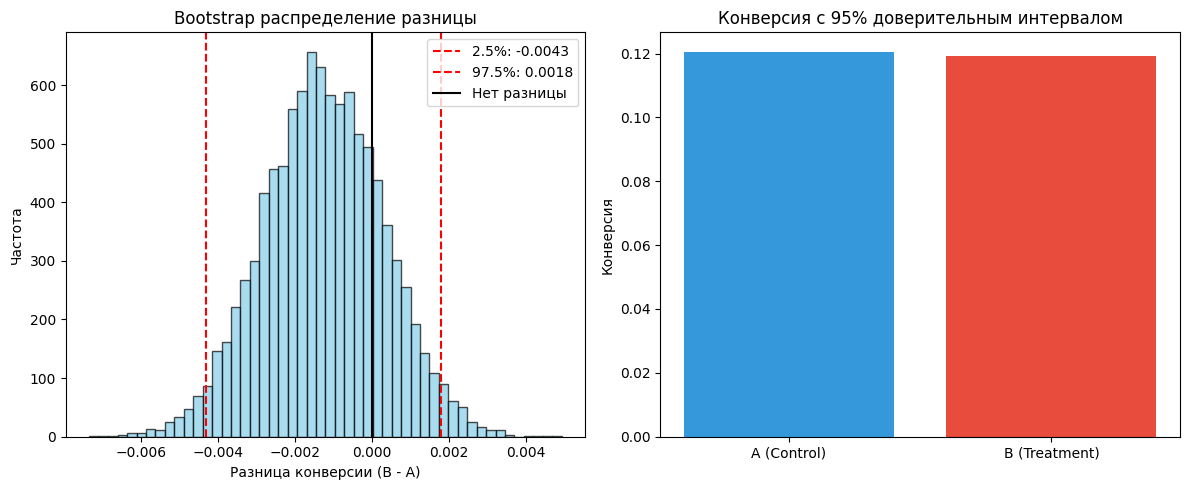

95% доверительный интервал для разницы: [-0.0043, 0.0018]
Интервал включает 0 — разница не значима


In [101]:
import numpy as np

def bootstrap_ci(data1, data2, n_bootstrap=10000):
    """Bootstrap доверительный интервал для разницы средних"""
    diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        diffs.append(sample2.mean() - sample1.mean())

    diffs = np.array(diffs)
    ci_lower = np.percentile(diffs, 2.5)
    ci_upper = np.percentile(diffs, 97.5)

    return diffs, ci_lower, ci_upper

diffs, ci_lower, ci_upper = bootstrap_ci(contr_conv, treatm_conv)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(diffs, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(ci_lower, color='red', linestyle='--', label=f'2.5%: {ci_lower:.4f}')
plt.axvline(ci_upper, color='red', linestyle='--', label=f'97.5%: {ci_upper:.4f}')
plt.axvline(0, color='black', linestyle='-', label='Нет разницы')
plt.xlabel('Разница конверсии (B - A)')
plt.ylabel('Частота')
plt.title('Bootstrap распределение разницы')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(['A (Control)', 'B (Treatment)'],
        [contr_conv.mean(), treatm_conv.mean()],

        capsize=10,
        color=['#3498db', '#e74c3c'])
plt.ylabel('Конверсия')
plt.title('Конверсия с 95% доверительным интервалом')

plt.tight_layout()
plt.savefig('bootstrap_data.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"95% доверительный интервал для разницы: [{ci_lower:.4f}, {ci_upper:.4f}]")
if ci_lower > 0:
    print("Интервал целиком выше 0 — значимое улучшение")
elif ci_upper < 0:
    print("Интервал целиком ниже 0 — значимое ухудшение")
else:
    print("Интервал включает 0 — разница не значима")

### Анализ по странам

In [104]:

for country in df_final['country'].unique():
    country_data = df_final[df_final['country'] == country]

    conv_by_group = country_data.groupby('group')['converted'].mean() * 100

    print(f"\n{country}:")
    print(f"  Control: {conv_by_group.get('control', 0):.2f}%")
    print(f"  Treatment: {conv_by_group.get('treatment', 0):.2f}%")

    # Тест для этой страны
    control_c = country_data[country_data['group'] == 'control']['converted']
    treatment_c = country_data[country_data['group'] == 'treatment']['converted']

    if len(control_c) > 0 and len(treatment_c) > 0:
        successes = [sum(control_c), sum(treatment_c)]
        nobs = [len(control_c), len(treatment_c)]
        z, p = proportions_ztest(successes, nobs)
        print(f"  p-value: {p:.4f}")


US:
  Control: 11.93%
  Treatment: 11.83%
  p-value: 0.5925

CA:
  Control: 12.21%
  Treatment: 11.67%
  p-value: 0.4348

UK:
  Control: 12.39%
  Treatment: 12.27%
  p-value: 0.6970


Соответсвенно во всех 3 странах  внедрение новой страницы не имеет убедительных причин.

##Выводы по A/B тестированию
1. Результаты эксперимента
Контрольная группа (старая страница): конверсия 12.06%

Экспериментальная группа (новая страница): конверсия 11.93%

Разница: -0.13 процентных пункта (-1.06% относительного снижения)

2. Статистическая значимость
Z-тест: p-value = 0.4125

      Chi2: p-value= 0.4167

Уровень значимости: α = 0.05

Вывод: p-value > α → разница статистически НЕ значима

3. Интерпретация
Несмотря на то, что новая страница показала чуть более низкую конверсию, эта разница может быть объяснена случайностью. Мы не можем уверенно утверждать, что новая версия хуже старой.

##Рекомендации:
- аккуратно оставить прежнюю страницу;
- внедрение новой страницы не имеет весомых причин и не имеет значимого рещультата;
- попытаться применить другую стратегию для обновления сайта.

A/B тестирование новой версии landing page (n=172,368 пользователей):
- Проведен полный анализ данных (очистка, проверка корректности теста)
- Рассчитана конверсия: контрольная группа 12.06% vs экспериментальная 11.93%
- Статистический анализ (z-test, chi2, bootstrap) показал отсутствие значимых различий (p=0.4125)
- Сформулированы бизнес-рекомендации: не внедрять изменения, искать другие гипотезы